In [ ]:
import numpy as np

import data_prep
import inference_utils

import warnings
from tqdm import tqdm
import itertools

warnings.filterwarnings('ignore')


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
main_dir = './DR8/' #Directory with daataset

### Parameters for data extraction

In [106]:
# Chose only a subset of the data 
speakers = [0,1]
n_sentence = -1

bands=6 # number of frequency bands
target_time_steps=8 # number of interpolation points

### Extracting data

We create the following variables from the data:
- all_syllable_labels (list) : List containing the labels of all spoken syllables in the dataset
- unique_syllable_labels (list) : List containing the unique syllable labels (lexical syllables) that appear in the dataset
- num_syll, num_syll_total (int) : number of labels and sopken syllables, respectively
- count_syll (dict) : number of occurence of each label
- classes (list) : mapping between the index of the spoken syllables and the index of their corresponding label
- count_classes (dict) : number of occurence of each class (same as count_syll but with the class index as key)
- class2idx : mapping from labels to class index

- all_aligned_words (list of list) : Each element corresponds to a sentence, and corresponds to its decomposition in words/groups of words
- all_aligned_sylls (list of list of list) : Same thing, but the words are also decomposed in their corresponding sequence of (lexical) syllables
- unique_words_sequences (list of list of list): list of the unique elements of all_aligned_sylls
- num_words : nuimber of unique words in the dataset

- all_spectrograms (list) : list of spectrograms of sopken syllables

- nans, gaps (list) : list of sentences where we found nan values in the spectrograms, or "gap syllables", respectively


In [107]:
all_syllable_labels, all_spectrograms, all_aligned_sylls, all_aligned_words, gaps, nans = data_prep.get_data(main_dir, speakers, n_sentence, bands, target_time_steps)

unique_syllable_labels = list(np.unique(all_syllable_labels))

num_syll = len(unique_syllable_labels)
num_syll_total = len(all_syllable_labels)

count_syll = {syll:len(np.where(np.array(all_syllable_labels)==syll)[0]) for syll in unique_syllable_labels} # number of occurence of each syllable

classes = [unique_syllable_labels.index(syll) for syll in all_syllable_labels]
count_classes = {i:len(np.where(np.array(classes)==i)[0]) for i in classes}

class2idx = {s:i for i,s in enumerate(unique_syllable_labels)}
syll2idx = {s: i for i, s in enumerate(unique_syllable_labels)}


unique_words_sequences = []
for seq in all_aligned_sylls:
    if seq not in unique_words_sequences:
        unique_words_sequences.append(seq)
num_words = len(unique_words_sequences)

Gap found in sentence, skipping
Gap found in sentence, skipping
NaN found in spectrogram for FBCG1/SX352, skipping
Gap found in sentence, skipping


### Computing embeddings

In [108]:
dtw_tensor = data_prep.compute_dtw(all_spectrograms) #DTW pairwise distance matrix

 
embedding_dim = 8 # Dimensions of the embeddings
num_epochs = 10000 # Number of epochs for training the embeddings
embedding = data_prep.compute_embeddings(dtw_tensor, num_syll_total, embedding_dim, num_epochs)

100%|██████████| 10000/10000 [03:12<00:00, 52.03it/s]


### Learning the posterior with SBI

In [109]:
simulator = inference_utils.build_simulator(embedding, all_spectrograms, 0.05) # Simulator for the generative model 


inference, density_estimator = inference_utils.compute_density_estimator(simulator, embedding, num_simulations=10000, estimator='mdn')
posterior = inference.build_posterior(density_estimator)

  0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 81 epochs.

In [110]:
path_list = data_prep.get_path_list(main_dir, speakers, n_sentence, gaps, nans)

100%|██████████| 2/2 [00:00<00:00, 210.84it/s]


### Testing the model example sentences

In [122]:
for path in path_list[:2]:
    aligned_sylls, spectrograms = inference_utils.extract_from_path(path, bands, target_time_steps)


    words, sylls = inference_utils.sequential_inference(aligned_sylls, spectrograms, 
                                         embedding, 
                                        posterior, 
                                        unique_words_sequences,
                                        unique_syllable_labels,
                                        classes, count_classes, 
                                        T1=1e0, T2=1e0,
                                        beta=.5
                                        )
    
    true_sentence = ""
    inferred_sentence = ""
    for i in range(len(aligned_sylls)):
        true_sentence += all_aligned_words[all_aligned_sylls.index(aligned_sylls[i])] + " "
        inferred_sentence += all_aligned_words[all_aligned_sylls.index(words[i])] + " "

    true_sentence = true_sentence[:-1]
    true_sentence += "."

    inferred_sentence = inferred_sentence[:-1]
    inferred_sentence += "."

    print(f"True sentence : {true_sentence}")
    print(f"Inferred sentence : {inferred_sentence}")

True sentence : she had your dark suit in greasy wash water all year.
Inferred sentence : she had your don't ask me suit in greasy wash water all year.
True sentence : don't ask me to carry an oily rag like that.
Inferred sentence : don't ask me be carry an oily rag like that.


### Comparing performance between full model and reduced model

In order to remove top-down predictions, we put the value of $\texttt{beta}$ to 0.

For evaluation on noisy speech, add an argument $\texttt{noise\_params=[q,snr]}$ to the $\texttt{extract\_from\_path}$ function, where $\texttt{q}$ is the proportion of noisy syllables (float between 0 and 1), and $\texttt{snr}$ is the Signal-to-Noise Ratio. 

Note : for low SNRs (<2.5) sometimes the posterior estimator runs forever without converging, so if you notice a sentence taking an abnormal amount of time to be processed (you can keep track with the tqdm progress bar), consider killing the cell and running it again.

In [114]:
perf_words = []
perf_sylls = []

perf_words_reduced = []
perf_sylls_reduced = []

for path in tqdm(path_list):

    aligned_sylls, spectrograms = inference_utils.extract_from_path(path, bands, target_time_steps)

    # Uncomment next line for speech-in-noise
    # aligned_sylls, spectrograms = inference_utils.extract_from_path(path, bands, target_time_steps, noise_params=[0.25, 5])


    words, sylls = inference_utils.sequential_inference(aligned_sylls, spectrograms, 
                                         embedding, 
                                        posterior, 
                                        unique_words_sequences,
                                        unique_syllable_labels,
                                        classes, count_classes, 
                                        T1=1e0, T2=1e0,
                                        beta=.5
                                        )
    
    words_reduced, sylls_reduced = inference_utils.sequential_inference(aligned_sylls, spectrograms, 
                                         embedding, 
                                        posterior, 
                                        unique_words_sequences,
                                        unique_syllable_labels,
                                        classes, count_classes, 
                                        T1=1e0, T2=1e0,
                                        beta=.0
                                        )
    
    perf_words.extend([int(words[i]==aligned_sylls[i]) for i in range(len(words))])
    perf_sylls.extend([int(sylls[i]==list(itertools.chain.from_iterable(aligned_sylls))[i]) for i in range(len(sylls))])

    perf_words_reduced.extend([int(words_reduced[i]==aligned_sylls[i]) for i in range(len(words))])
    perf_sylls_reduced.extend([int(sylls_reduced[i]==list(itertools.chain.from_iterable(aligned_sylls))[i]) for i in range(len(sylls))])



100%|██████████| 15/15 [01:37<00:00,  6.51s/it]


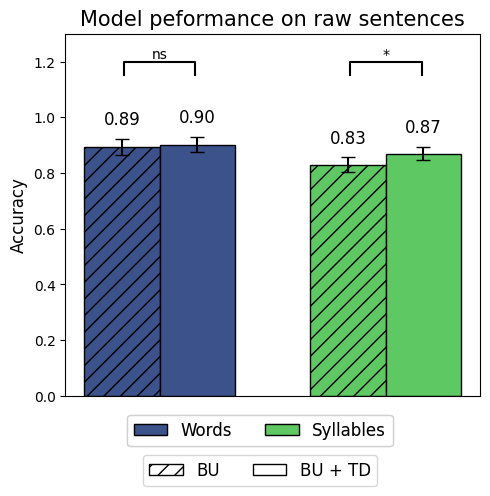

In [116]:
inference_utils.compare_performance(perf_words, perf_words_reduced, perf_sylls, perf_sylls_reduced)